In [1]:
"""
2018-4-21:
we have finished outlier looking at last notebook, now let's check out missing values.
training&valid best 0.9221654742823935
Kaggle improved from 1614 -> 1202 (with log rsme score = 0.12567)
It seems removing outlier definitely helps, but not that much given we don't have that many outliers

2018-4-20:

Ok, after work1, and XGBoost edition1, i have applied it and got some score of this House Price Prediction
Challenge. 

Now the goal is to learn from the top perfomers and learn how to make up the difference.
The first one I found is <Data Pre-Processing> --- how to treat missing values and outliers
ref: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

Here we go
"""


import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#this is cool:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [29]:
dirctory = os.getcwd()

o_train = pd.read_csv(str(dirctory)+"/kaggle_house_pred_train.csv")
train = pd.read_csv(str(dirctory)+"/train1.csv")
test = pd.read_csv(str(dirctory)+"/kaggle_house_pred_test.csv")
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))
print(train.shape)

(1438, 80)


In [30]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [31]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing_Ratio' :all_data_na})
missing_data.head(20)
# show the precentage of missing data from each feature from train+test data

,Missing_Ratio
PoolQC,99.689
MiscFeature,96.652
Alley,93.269
Fence,80.463
FireplaceQu,48.809
LotFrontage,16.569
GarageFinish,5.385
GarageYrBlt,5.385
GarageQual,5.385
GarageCond,5.385


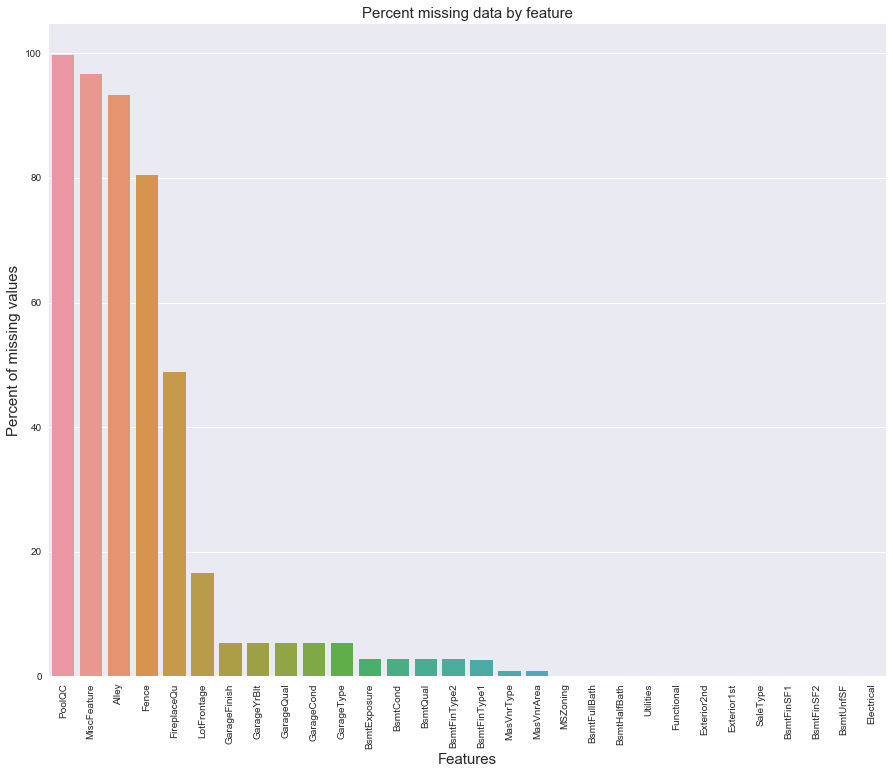

In [32]:
#fancy plot of the above ratios!~

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [33]:
missing_data.index[:5]

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')

In [ ]:
list(missing_data.index[20:30])

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["GarageFinish"] = all_data["GarageFinish"].fillna("None")
all_data["GarageQual"] = all_data["GarageQual"].fillna("None")
all_data["GarageCond"] = all_data["GarageCond"].fillna("None")
all_data["GarageType"] = all_data["GarageType"].fillna("None")
#something super cool!!!
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
#all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0]) #fill na with most common ticket
all_data['MSZoning'] = all_data['MSZoning'].fillna("Unknown")
all_data['Utilities'] = all_data['Utilities'].fillna("Unknown")
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data["KitchenQual"] = all_data["KitchenQual"].fillna("Typ")
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])


In [23]:
all_X[list(missing_data.index[:12])].head()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageFinish,GarageYrBlt,GarageQual,GarageCond,GarageType,BsmtExposure
0,NaN,NaN,NaN,NaN,NaN,65.000,RFn,2003.000,TA,TA,Attchd,No
1,NaN,NaN,NaN,NaN,TA,80.000,RFn,1976.000,TA,TA,Attchd,Gd
2,NaN,NaN,NaN,NaN,TA,68.000,RFn,2001.000,TA,TA,Attchd,Mn
3,NaN,NaN,NaN,NaN,Gd,60.000,Unf,1998.000,TA,TA,Detchd,No
4,NaN,NaN,NaN,NaN,TA,84.000,RFn,2000.000,TA,TA,Attchd,Av


In [39]:
# for i in list(missing_data.index[30:]):
#     print(i,all_X[str(i)].unique())
print(all_data['Functional'].unique())
print(all_data['Functional'].isnull().sum())

['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev' nan]
2


In [44]:
all_data['Functional'].mode()

0    Typ
dtype: object